In [17]:
from fast_bert.data_cls import BertDataBunch
from fast_bert.prediction import BertClassificationPredictor

from pathlib import Path
from box import Box

import torch

from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging

In [18]:
import pandas as pd
data = pd.read_csv('train.csv')

data = data.dropna()
data['ID'] = data['ID'].astype(int)
data['feeling'] = data['feeling'].astype(int)

porcentagem_val = 0.2

data_shuffled = data.sample(frac=1, random_state=42)

n_val = int(len(data) * porcentagem_val)

val_data = data_shuffled[:n_val]
train_data = data_shuffled[n_val:]

val_data.to_csv('val.csv', index=False)
train_data.to_csv('train.csv', index=False)
print("ok")

ok


In [19]:
# Box is a nice wrapper to create an object from a json dict
# args = Box({
#     "seed": 42,
#     "task_name": 'tweet-classification',
#     "model_name": 'roberta-base',
#     "model_type": 'roberta',
#     "train_batch_size": 16,
#     "learning_rate": 4e-5,
#     "num_train_epochs": 20,
#     "fp16": True,
#     "fp16_opt_level": "O2",
#     "warmup_steps": 1000,
#     "logging_steps": 0,
#     "max_seq_length": 512,
#     "multi_gpu": True if torch.cuda.device_count() > 1 else False
# })
model_type = ["bert"]
DATA_PATH = Path('./')
LABEL_PATH = Path('./')
LOG_PATH = Path('./logs')
MODEL_PATH = Path('./lm_model_{}/'.format(model_type))
OUTPUT_DIR = Path('./output')

MODEL_PATH.mkdir(exist_ok=True)
LOG_PATH.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)


In [20]:
databunch = BertDataBunch(DATA_PATH, LABEL_PATH,
                          tokenizer='bert-base-cased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='labels.csv',
                          text_col='text',
                          label_col='feeling',
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')

/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/fast_bert/data_cls.py:564: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowl

In [21]:
logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-cased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir=OUTPUT_DIR,
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True,
						is_fp16=True,
						multi_label=False,
						logging_steps=50)

/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/transformers/modeling_utils.py:371: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicit

  0%|          | 0/100 [00:00<?, ?it/s]

/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/fast_bert/learner_cls.py:914: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/pytorch_lamb/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1581.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Learning rate search finished. See the graph with {finder_name}.plot()


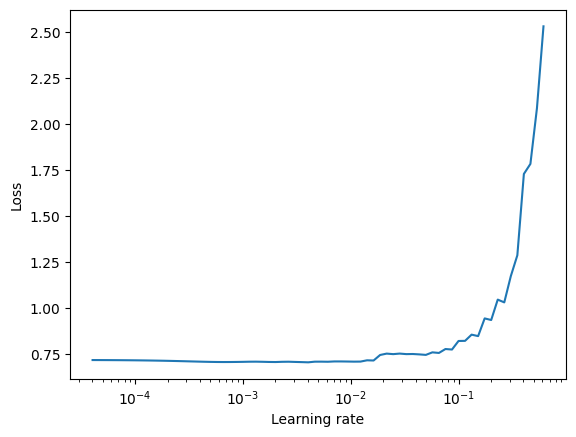

TypeError: write() argument must be str, not float

In [22]:
learner.lr_find(start_lr=1e-5,optimizer_type='lamb')
with open("./learning_rate.txt", "w") as file:
	file.write(learner.learning_rate.__str__())

In [23]:
learner.fit(epochs=6,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")

/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/fast_bert/learner_cls.py:618: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/azure/.conda/envs/Hackathon/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:374: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


(2268, 0.6607836634183477)

In [24]:
learner.save_model()

In [25]:
# predictions = learner.predict_batch(texts)
# 
# 
# 
# ou
# 
# 
# 
MODEL_PATH = OUTPUT_DIR/'model_out'

predictor = BertClassificationPredictor(
				model_path=MODEL_PATH,
				label_path=LABEL_PATH, # location for labels.csv file
				multi_label=False,
				model_type='bert',
				do_lower_case=False,
				device=device_cuda) # set custom torch.device, defaults to cuda if available
# 
# # Single prediction
# single_prediction = predictor.predict("just get me result for this text")
# 
# # Batch predictions
# texts = [
# 	"this is the first text",
# 	"this is the second text"
# 	]

NameError: name 'BertClassificationPredictor' is not defined

In [29]:
reader = pd.read_csv("test.csv")
test_x = [str(x) for x in reader['text'].array]
test_ids = [float(x) for x in reader['ID'].array]

multiple_predictions = predictor.predict_batch(test_x)

with open("./teste.txt", "w") as file:
	file.write(multiple_predictions.__str__())
# with open(f"{model_type}/predictions.csv", "w") as file:
# 	file.write("ID,feeling\n")
# 	for test_id, prediction in zip(test_ids, multiple_predictions):
# 		accu_0, accu_1 = prediction
# 		if accu_0 > accu_1:
# 			feeling = 0
# 		else:
# 			feeling = 1
#     	file.write(f"{test_id},{feeling}\n")

NameError: name 'predictor' is not defined